<a href="https://colab.research.google.com/github/adityaghai07/ML-Projects/blob/main/makemore_indie_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian Name Generator with indie-makemore!

**Hi! Aditya here!**

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/aditya-ghai/)  
[![YouTube](https://img.shields.io/badge/YouTube-FF0000?style=for-the-badge&logo=youtube&logoColor=white)](https://www.youtube.com/@adityaghai220/videos)



## Overview

This project implements a multilayer perceptron (MLP) character-level language model for generating Indian names, inspired by Andrej Karpathy's makemore neural network series. The model learns to generate realistic Indian names by understanding character-level patterns and dependencies.

## Background

Based on the seminal work by Bengio et al. (2003) on neural probabilistic language models, this implementation demonstrates how neural networks can learn to model language at the character level using bigram-based context.

## Dataset

- **Source:** [Indian-Names.csv](https://gist.githubusercontent.com/mbejda/7f86ca901fe41bc14a63/raw/38adb475c14a3f44df9999c1541f3a72f472b30d/Indian-Male-Names.csv)

## Architecture

### Embedding Lookup Table
- Maps each character to a dense vector representation ( 5 dimensions per character)
- Learnable parameters that capture character semantics

### Multilayer Perceptron (MLP)
- Hidden layers with tanh activations
- Learns complex patterns in character sequences
- Outputs probability distribution over possible next characters

## References

1. Bengio, Y., Ducharme, R., Vincent, P., & Jauvin, C. (2003).[ A neural probabilistic language model. Journal of Machine Learning Research, 3, 1137-1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
2. Karpathy, A.  [nn-zero-to-hero: Neural Networks from Scratch](https://github.com/karpathy/nn-zero-to-hero)

In [2]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd
import re

url = "https://gist.githubusercontent.com/mbejda/7f86ca901fe41bc14a63/raw/38adb475c14a3f44df9999c1541f3a72f472b30d/Indian-Male-Names.csv"


df = pd.read_csv(url)

df = df.dropna(subset=["name"])


first_names = df["name"].apply(lambda x: str(x).split()[0].lower())
words = [name for name in first_names if re.fullmatch(r'[a-z]+', name)]

print(words[:10])

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = { i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 3

X,Y =[],[]

for w in words[:5]:
  context = [0]*block_size
  for ch in w+'.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]


X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
#let us build the dataset!!

block_size = 3 #context length


def build_dataset(words):
  X,Y =[],[]

  for w in words:

    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
      # print(context)


  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([78993, 3]) torch.Size([78993])
torch.Size([9948, 3]) torch.Size([9948])
torch.Size([9844, 3]) torch.Size([9844])


In [6]:
C = torch.randn((27,5))


In [7]:
emb = C[Xtr]
emb.shape

torch.Size([78993, 3, 5])

In [8]:
W1 = torch.randn((15,100))
b1 = torch.randn(100)

In [9]:
h = torch.tanh(emb.view(-1,15) @ W1 + b1)

In [10]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [11]:
logits = h @ W2  + b2

In [12]:
logits.shape

torch.Size([78993, 27])

In [13]:
counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True)
prob.shape

torch.Size([78993, 27])

In [14]:
loss = - prob[torch.arange(len(Xtr)),Ytr].log().mean()
loss

tensor(15.5280)

In [15]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 5), generator=g)
W1 = torch.randn((15, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [16]:
sum(p.nelement() for p in parameters) # number of parameters in total

8762

In [17]:
for p in parameters:
  p.requires_grad = True

In [18]:
lri = []
lossi = []
stepi = []

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
from tqdm import tqdm

In [21]:
for i in tqdm(range(200000)):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))

  # forward pass
  emb = C[Xtr[ix]] # (64, 3, 5)
  h = torch.tanh(emb.view(-1, 15) @ W1 + b1) # (64, 200)
  logits = h @ W2 + b2 # (64, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

100%|██████████| 200000/200000 [02:36<00:00, 1277.32it/s]


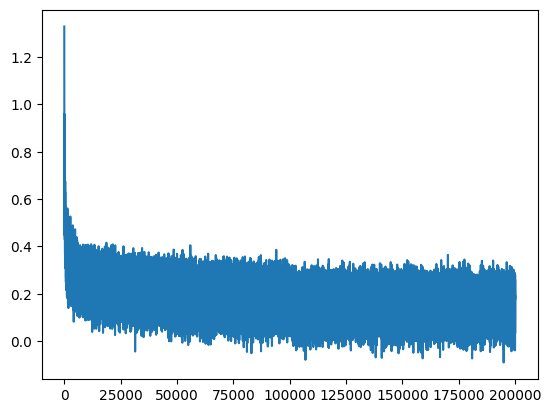

In [22]:
plt.plot(stepi, lossi)

In [23]:
emb = C[Xtr]
print(emb.shape)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

torch.Size([78993, 3, 5])


tensor(1.4481, grad_fn=<NllLossBackward0>)

In [24]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.6013, grad_fn=<NllLossBackward0>)

In [25]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mohankananheeek.
nd.
rampal.
murajendra.
guldeepak.
lit.
shivam.
rakesh.
suraj.
sameet.
sharamnosh.
bar.
shivam.
raj.
jogesh.
pant.
rohit.
man.
deepak.
umanh.


In [25]:
# Bonus: There is a bias in the generation, can you find it?